## Semantic Segmentation of Images
 * Images of cats and dogs, will be distinguished from their background.
 * The Oxford-IIIT Pets dataset (www.robots.ox.ac.uk/~vgg/data/pets/) , contains 7,390 pictures of various breeds of cats and dogs, together with foreground-background segmentation masks for each picture.

In [1]:
# downloading and uncompressing our dataset, using the wget and tar shell utilities
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

--2022-10-18 22:31:10--  http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz [following]
--2022-10-18 22:31:11--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz [following]
--2022-10-18 22:31:11--  https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7

* The input pictures are stored as JPG files in the images/ folder (such as images/Abyssinian_1.jpg)
* The corresponding segmentation mask is stored as a PNG file with the same name in the annotations/trimaps/ folder (such as annotations/trimaps/Abyssinian_1.png).
* Prepare the list of input file paths, as well as the list of the corresponding mask file paths.

In [2]:
# prepare the list of input file paths, as well as the list of the corresponding mask file paths
import os

input_dir = "images/"
target_dir = "annotations/trimaps/"

input_img_paths = sorted(
    [os.path.join(input_dir, fname)
    for fname in os.listdir(input_dir)
    if fname.endswith(".jpg")
    ]
    )

In [3]:
target_paths = sorted(
    [os.path.join(target_dir, fname)
    for fname in os.listdir(target_dir)
    if fname.endswith(".png") and not fname.startswith(".")
    ]
    )

In [4]:
import tensorflow as tf
from tensorflow import keras

from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
from PIL import ImageOps


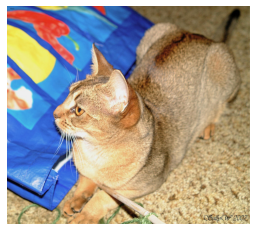

In [5]:
# Review the inputs which is in position 9
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array
plt.axis("off")
plt.imshow(load_img(input_img_paths[9]))

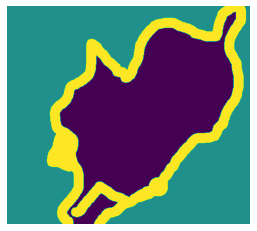

In [6]:
# Display corresponding segemntation mask
def display_target(target_array):
  # The original labels are 1, 2, and 3. 
  # Subtract 1 so that the labels range from 0 to 2
  # Then multiply by 127 so that  the labels become 0 (black), 127 (gray), 254 (near-white).
  normalized_array = (target_array.astype("uint8") - 1) * 127
  plt.axis("off")
  plt.imshow(normalized_array[:, :, 0])

# Use color_mode="grayscale" so that the image we load is treated as having a single color channel
# review image 9 segmentation mask
img = img_to_array(load_img(target_paths[9], color_mode="grayscale"))
display_target(img)

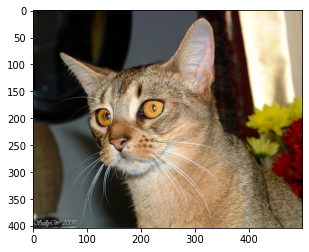

In [7]:
# review image 10
plt.imshow(load_img(input_img_paths[10]))

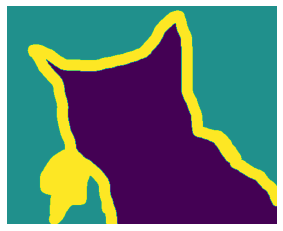

In [8]:
# review image 10 segmentation mask
img = img_to_array(load_img(target_paths[10], color_mode="grayscale"))
display_target(img)

* Load inputs and targets into two NumPy arrays, and split the arrays into a training and a validation set. 
* The dataset is very small, and can just load everything into memory.

In [9]:
import numpy as np
import random

# resize everything to 200 × 200.
img_size = (200, 200)

# Total number of samples in the data
num_imgs = len(input_img_paths)

# Shuffle the file paths. 
# Use the same seed (1337) in both statements to ensure that the input paths and target paths stay in the same order.
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_paths)

In [10]:
# convert the input image from file path in jpeg format into an actual image array
def path_to_input_image(path):
  return img_to_array(load_img(path, target_size=img_size))

# convert the target labels from file path in png format into an actual image array
def path_to_target(path):
  img = img_to_array(
  load_img(path, target_size=img_size, color_mode="grayscale"))
  # Subtract 1 so that labels start become 0, 1, and 2.
  img = img.astype("uint8") - 1
  return img

In [11]:
# Load all images in the input_imgs float32 array and their masks in the targets uint8 array (same order). 
# The inputs have three channels (RBG values) and the targets have a single channel (which contains integer labels).

input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype="float32")
targets = np.zeros((num_imgs,) + img_size + (1,), dtype="uint8")
for i in range(num_imgs):
  input_imgs[i] = path_to_input_image(input_img_paths[i])
  targets[i] = path_to_target(target_paths[i])

In [12]:
# Reserve 1,000 samples for validation.
num_val_samples = 1000

In [13]:
# Split the data into a training and a validation set.

# train dataset
train_input_imgs = input_imgs[:-num_val_samples]
train_targets = targets[:-num_val_samples]

# validation dataset
val_input_imgs = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:]

### Model construction for semantic segmentation of images
* Conv2D downsamples an image
* Conv2DTranspose upsamples the input data passed to it

In [14]:
from tensorflow import keras
from tensorflow.keras import layers

In [15]:
def get_model(img_size, num_classes):
  inputs = keras.Input(shape=img_size + (3,))
  
  # rescale input images to the [0-1] range.
  x = layers.Rescaling(1./255)(inputs)
  
  # Use padding="same" everywhere to avoid the influence of border padding on feature map size
  x = layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(x)
  x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
  x = layers.Conv2D(128, 3, strides=2, activation="relu", padding="same")(x)
  x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
  x = layers.Conv2D(256, 3, strides=2, padding="same", activation="relu")(x)
  x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)
  x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same")(x)
  x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same", strides=2)(x)
  x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
  x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same", strides=2)(x)
  x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
  x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same", strides=2)(x)
 
  # End the model with a per-pixel three-way softmax to classify each output pixel into one of three categories
  outputs = layers.Conv2D(num_classes, 3, activation="softmax",padding="same")(x)

  model = keras.Model(inputs, outputs)

  return model

In [16]:
# build the model
model = get_model(img_size=img_size, num_classes=3)

In [17]:
# Review the model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 128)       147584    
                                                                 
 conv2d_4 (Conv2D)           (None, 25, 25, 256)       295168

In [18]:
# Compile the model
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

In [19]:
# Set the callbacks
callbacks = [keras.callbacks.ModelCheckpoint("oxford_segmentation.keras",
                                             save_best_only=True)
]

In [20]:
# train the model
history = model.fit(train_input_imgs, train_targets,
                    epochs=50,
                    callbacks=callbacks,
                    batch_size=64,
                    validation_data=(val_input_imgs, val_targets))

Epoch 1/50
100/100 [==============================] - 4690s 47s/step - loss: 2.7309 - val_loss: 0.9986
Epoch 2/50
100/100 [==============================] - 4660s 47s/step - loss: 0.9215 - val_loss: 0.8424
Epoch 3/50
 32/100 [========>.....................] - ETA: 50:25 - loss: 0.8553

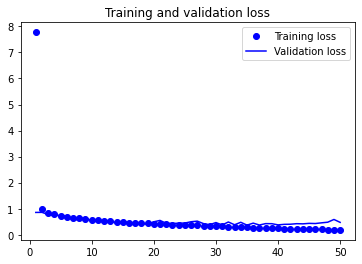

In [22]:
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

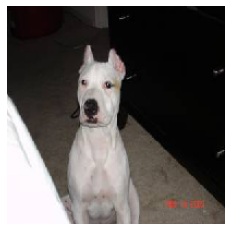

In [24]:
# demonstrate how to predict a segmentation mask
from tensorflow.keras.utils import array_to_img
model = keras.models.load_model("oxford_segmentation.keras")

# Test Image for Semantic Segmentation
i = 4
test_image = val_input_imgs[i]
plt.axis("off")
plt.imshow(array_to_img(test_image))

1/1 [==============================] - 0s 216ms/step


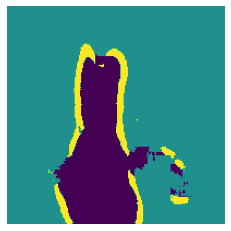

In [25]:



# Utility to display a model’s prediction
def display_mask(pred):
  mask = np.argmax(pred, axis=-1)
  mask *= 127
  plt.axis("off")
  plt.imshow(mask)

# Predict mask for test_image
mask = model.predict(np.expand_dims(test_image, 0))[0]

# use utility to display the semantic representation
display_mask(mask)

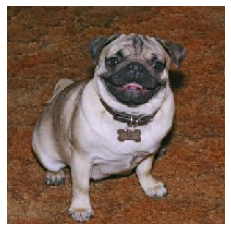

In [26]:
# Test Image for Semantic Segmentation
i = 10
test_image = val_input_imgs[i]
plt.axis("off")
plt.imshow(array_to_img(test_image))

1/1 [==============================] - 0s 26ms/step


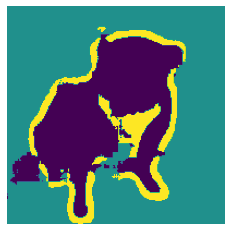

In [27]:
# Predict mask for test_image
mask = model.predict(np.expand_dims(test_image, 0))[0]

# use utility to display the semantic representation
display_mask(mask)